In [8]:
!pip install wandb torchvision matplotlib seaborn tensorboard scikit-learn opencv-python grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s 

In [5]:
import torch
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# download dataset

import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/corn-or-maize-leaf-disease-dataset


In [8]:

# list classes in the dataset

import os

classes = os.listdir(f'{path}/data')
print("Classes:", classes)


Classes: ['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# Normalize using ImageNet stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [10]:
# Split dataset into train, val, and test
dataset = ImageFolder(f'{path}/data')
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.targets)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_idx])

from torch.utils.data import Subset
train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms
test_data.dataset.transform = val_test_transforms

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [11]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [14]:
import wandb
wandb.init(project="maize-leaf-disease")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: faisaladamm (faisaladamm-matasacomm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
for epoch in range(10):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    wandb.log({"Train Loss": running_loss/len(train_loader), "Train Accuracy": train_acc})
    print("Train/Loss", running_loss/len(train_loader), 'Epoch:', epoch)
    print("Train/Accuracy:", train_acc, 'Epoch:', epoch)
    writer.add_scalar("Train/Loss", running_loss/len(train_loader), epoch)
    writer.add_scalar("Train/Accuracy", train_acc, epoch)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    wandb.log({"Val Loss": val_loss/len(val_loader), "Val Accuracy": val_acc})
    print("Val/Loss:", val_loss/len(val_loader), 'Epoch:', epoch)
    print("Val/Accuracy:", val_acc, 'Epoch:', epoch)
    writer.add_scalar("Val/Loss", val_loss/len(val_loader), epoch)
    writer.add_scalar("Val/Accuracy", val_acc, epoch)
    print('')

Train/Loss 0.029349926140691554 Epoch: 0
Train/Accuracy: 0.9916417910447761 Epoch: 0
Val/Loss: 0.10751790184128497 Epoch: 0
Val/Accuracy: 0.9689737470167065 Epoch: 0

Train/Loss 0.012941015191886219 Epoch: 1
Train/Accuracy: 0.9961194029850746 Epoch: 1
Val/Loss: 0.12275563716892586 Epoch: 1
Val/Accuracy: 0.964200477326969 Epoch: 1

Train/Loss 0.012899538099078373 Epoch: 2
Train/Accuracy: 0.9964179104477612 Epoch: 2
Val/Loss: 0.15696725464658812 Epoch: 2
Val/Accuracy: 0.954653937947494 Epoch: 2

Train/Loss 0.016975713755181504 Epoch: 3
Train/Accuracy: 0.9946268656716418 Epoch: 3
Val/Loss: 0.18596000164481147 Epoch: 3
Val/Accuracy: 0.9594272076372315 Epoch: 3

Train/Loss 0.018537591972632245 Epoch: 4
Train/Accuracy: 0.993731343283582 Epoch: 4
Val/Loss: 0.17612291263607663 Epoch: 4
Val/Accuracy: 0.9498806682577565 Epoch: 4

Train/Loss 0.020712375588759425 Epoch: 5
Train/Accuracy: 0.9928358208955224 Epoch: 5
Val/Loss: 0.15992012145995563 Epoch: 5
Val/Accuracy: 0.964200477326969 Epoch: 5

Tr

## Summary of a Training & Validation Performance

### My Key Observations
- The model shows **excellent training accuracy**, reaching **~99.8%** by Epoch 7.
- **Validation accuracy** is strong and stable, averaging **~96%**, with slight fluctuations.
- Some evidence of **overfitting** appears after Epoch 2, as training loss keeps decreasing but validation loss increases.

---

###  Epoch-by-Epoch Metrics

| Epoch | Train Loss | Train Acc | Val Loss | Val Acc |
|-------|------------|-----------|----------|---------|
| 0     | 0.0293     | 99.16%    | 0.1075   | 96.90%  |
| 1     | 0.0129     | 99.61%    | 0.1228   | 96.42%  |
| 2     | 0.0129     | 99.64%    | 0.1570   | 95.47%  |
| 3     | 0.0170     | 99.46%    | 0.1860   | 95.94%  |
| 4     | 0.0185     | 99.37%    | 0.1761   | 94.99%  |
| 5     | 0.0207     | 99.28%    | 0.1599   | 96.42%  |
| 6     | 0.0084     | 99.70%    | 0.1623   | 96.66%  |
| 7     | 0.0067     | 99.76%    | 0.1761   | 96.42%  |
| 8     | 0.0124     | 99.61%    | 0.1605   | 96.66%  |
| 9     | 0.0239     | 99.22%    | 0.1622   | 95.23%  |

---

### My Interpretation based on Epochs

- **Early Performance (Epochs 0–2)**: Rapid learning and generalization — ideal phase.
- **Middle Epochs (3–5)**: Overfitting begins. Val loss increases while train loss decreases.
- **Later Epochs (6–9)**: Train performance continues improving. Validation stabilizes but does not improve beyond Epoch 0–1.



In [22]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

                precision    recall  f1-score   support

        Blight       0.88      0.93      0.91       115
   Common_Rust       0.98      0.97      0.97       130
Gray_Leaf_Spot       0.87      0.79      0.83        58
       Healthy       1.00      1.00      1.00       116

      accuracy                           0.94       419
     macro avg       0.93      0.92      0.93       419
  weighted avg       0.94      0.94      0.94       419

Confusion Matrix:
 [[107   2   6   0]
 [  3 126   1   0]
 [ 11   1  46   0]
 [  0   0   0 116]]


## Classification Report Interpretation

This classification report evaluates the model's predictions on the test set. Below is an analysis of how well the model performs across each maize leaf category.

###  Summary

- **Overall Accuracy**: **94%**  
- **Macro Avg F1-Score**: **0.93**  
- **Weighted Avg F1-Score**: **0.94**

---

### Class-wise Performance

| Class             | Precision | Recall | F1-Score | Support |
|-------------------|-----------|--------|----------|---------|
| **Blight**        | 0.88      | 0.93   | 0.91     | 115     |
| **Common Rust**   | 0.98      | 0.97   | 0.97     | 130     |
| **Gray Leaf Spot**| 0.87      | 0.79   | 0.83     | 58      |
| **Healthy**       | 1.00      | 1.00   | 1.00     | 116     |

**Interpretation:**

-  **Healthy** leaves were perfectly classified with **100% precision and recall**.
-  **Gray Leaf Spot** has the **lowest recall (0.79)**, indicating some confusion with other disease classes.
-  **Common Rust** is the most confidently detected disease, with both high precision and recall.
-  **Blight** also performs well, but slightly lower precision (0.88) due to some false positives.

---

###  Confusion Matrix

|                | Pred: Blight | Pred: Rust | Pred: Gray | Pred: Healthy |
|----------------|--------------|------------|------------|----------------|
| **True Blight**     | 107          | 2          | 6          | 0              |
| **True Rust**       | 3            | 126        | 1          | 0              |
| **True Gray**       | 11           | 1          | 46         | 0              |
| **True Healthy**    | 0            | 0          | 0          | 116            |

**Insights:**
-  Most of the **Gray Leaf Spot** errors are misclassified as **Blight (11 cases)**.
-  Minimal confusion between **Healthy** and diseased categories.
-  Excellent separation between **Rust** and the other classes.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s

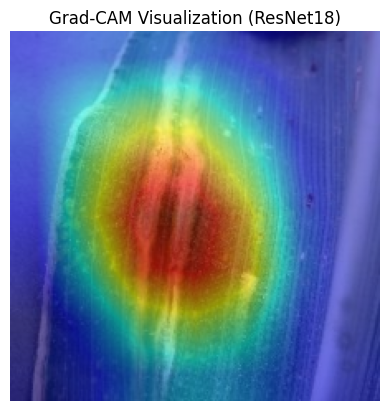

In [23]:
# Installing Grad-CAM library
!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Choosing the final convolutional layer for ResNet18
target_layer = model.layer4[-1]

# Set model to eval mode
model.eval()

# Run Grad-CAM (NO use_cuda argument!)
cam = GradCAM(model=model, target_layers=[target_layer])

# Select one image from test dataset
image_tensor, _ = test_data[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

# Generate CAM (ensure tensor is detached properly)
grayscale_cam = cam(input_tensor=input_tensor)[0]

# Denormalize image for display
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
image_np = image_np * np.array(std) + np.array(mean)
image_np = np.clip(image_np, 0, 1).astype(np.float32)

# Overlay Grad-CAM on image
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Display result
plt.imshow(visualization)
plt.title("Grad-CAM Visualization (ResNet18)")
plt.axis('off')
plt.show()

# Clean up manually to suppress __del__ warnings
del cam
torch.cuda.empty_cache()


testing

In [24]:

import random

# Get a list of random indices from the test dataset
random_indices = random.sample(range(len(test_data)), 10)

model.eval()
with torch.no_grad():
  for i in random_indices:
    image, actual_label_idx = test_data[i]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, predicted_label_idx = torch.max(output, 1)

    predicted_label = dataset.classes[predicted_label_idx.item()]
    actual_label = dataset.classes[actual_label_idx]

    print(f"Image {i}: Actual Label = {actual_label}, Predicted Label = {predicted_label}")
    print()

Image 404: Actual Label = Healthy, Predicted Label = Healthy

Image 95: Actual Label = Gray_Leaf_Spot, Predicted Label = Gray_Leaf_Spot

Image 17: Actual Label = Healthy, Predicted Label = Healthy

Image 57: Actual Label = Blight, Predicted Label = Blight

Image 401: Actual Label = Blight, Predicted Label = Gray_Leaf_Spot

Image 237: Actual Label = Gray_Leaf_Spot, Predicted Label = Gray_Leaf_Spot

Image 136: Actual Label = Common_Rust, Predicted Label = Common_Rust

Image 88: Actual Label = Common_Rust, Predicted Label = Common_Rust

Image 282: Actual Label = Healthy, Predicted Label = Healthy

Image 224: Actual Label = Common_Rust, Predicted Label = Common_Rust

